In [13]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)

import random
from tqdm import tqdm

from mtcnn.mtcnn import MTCNN
model = MTCNN()

from keras_facenet import FaceNet
embedder = FaceNet()

In [2]:
def load_images(path, image_type='.jpg'):
    images = []
    for file_path in glob.glob(os.path.join(path, f'*{image_type}')):
        images.append(cv2.imread(file_path))
        # Convert BGR to RGB
        images[-1] = images[-1][:, :, ::-1]
    return images

def new_load_images(glob_path):
    images = []
    for file_path in glob.glob(glob_path):
        images.append(cv2.imread(file_path))
        # Convert BGR to RGB
        images[-1] = cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB)
#         images[-1] = images[-1][:, :, ::-1]
    return images

def use_tqdm(iterable, desc=None, total=None):
    total = total or len(iterable)
    return tqdm(iterable, total=total, desc=desc, ncols=100, position=0, leave=True)

In [11]:
def encode_face(img):
    location = locate_faces(img)[:1]
    face_img = extract_faces(img, location)
    return embedder.embeddings(face_img)[0]

def encode_faces(img, locations):
    return embedder.embeddings(extract_faces(img, locations))

def extract_faces(img, locations):
    res_imgs = []
    for (y1, x1, y2, x2) in locations:
        res_imgs.append(img[y1:y2, x2:x1])
    return res_imgs

def draw_faces(img, locations, verbose=True):
    res_img = img.copy()
    for (y1, x1, y2, x2) in locations:
        cv2.rectangle(res_img, (x1, y2), (x2, y1), (0, 255, 0), 8)
    if verbose:
        plt.imshow(res_img)
        plt.show()
    return res_img

def locate_faces(img):
    faces = model.detect_faces(img)
    faces = [x['box'] for x in faces]
    faces = [(max(y, 0),
              min(x+w, img.shape[1]),
              min(y+h, img.shape[0]),
              max(x, 0)) for x, y, w, h in faces]
    return np.array(faces)

def face_distance(face1, face2):
    return np.linalg.norm(face1 - face2, axis=1)

def compare_faces(face1, face2, tolerance=0.9):
    return list(face_distance(face1, face2) <= tolerance)

In [4]:
# Load photo with the person
person_image = load_images('data', image_type='boris.jpg')[0]
person_name = 'Boris'

# person_image = load_images('data', image_type='ivan_2.jpg')[0]
# person_name = 'Ivan'

In [5]:
# Get person face features
person_encoding = encode_face(person_image).reshape(1, -1)

In [6]:
person_encoding.shape

(1, 512)

In [8]:
# List folders
folders = glob.glob('data/S*/*')
print(np.array(folders))

['data/Slippers of the Year 2019/boris'
 'data/Slippers of the Year 2019/ivan'
 'data/Slippers of the Year 2019/noone']


In [9]:
# Load images
images = []
for folder in folders[:3]:
    images.extend(load_images(folder))

# images = new_load_images('data/*/*/*.jpg')
images = np.array(images)
images.shape

(440,)

Finding faces in images:   0%|                                              | 0/440 [00:00<?, ?it/s]

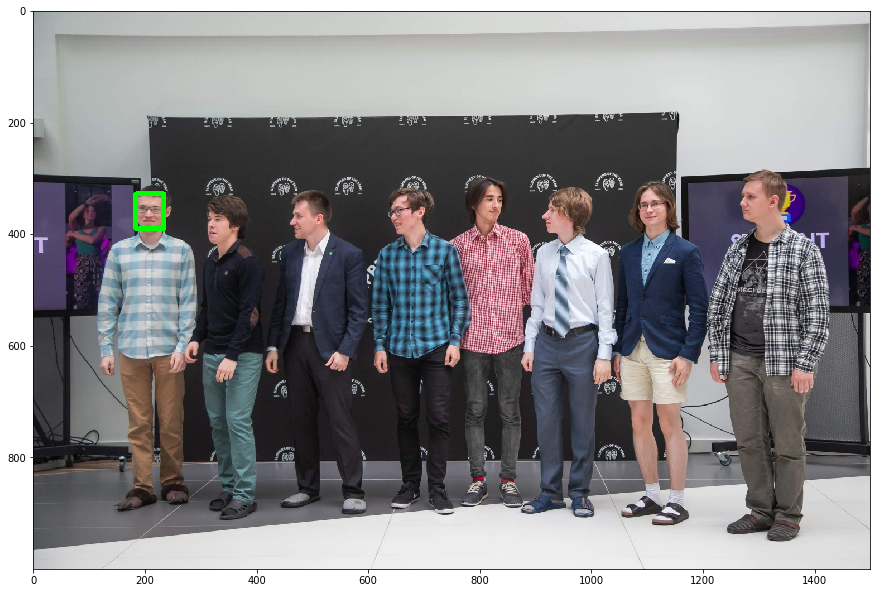

Finding faces in images:   0%|                                      | 1/440 [00:02<20:48,  2.84s/it]

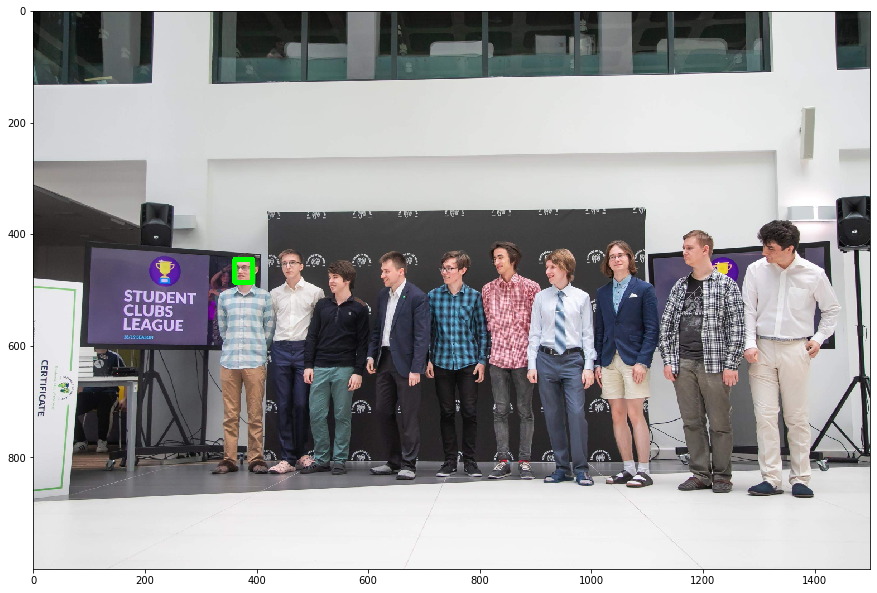

Finding faces in images:   0%|▏                                     | 2/440 [00:04<18:19,  2.51s/it]

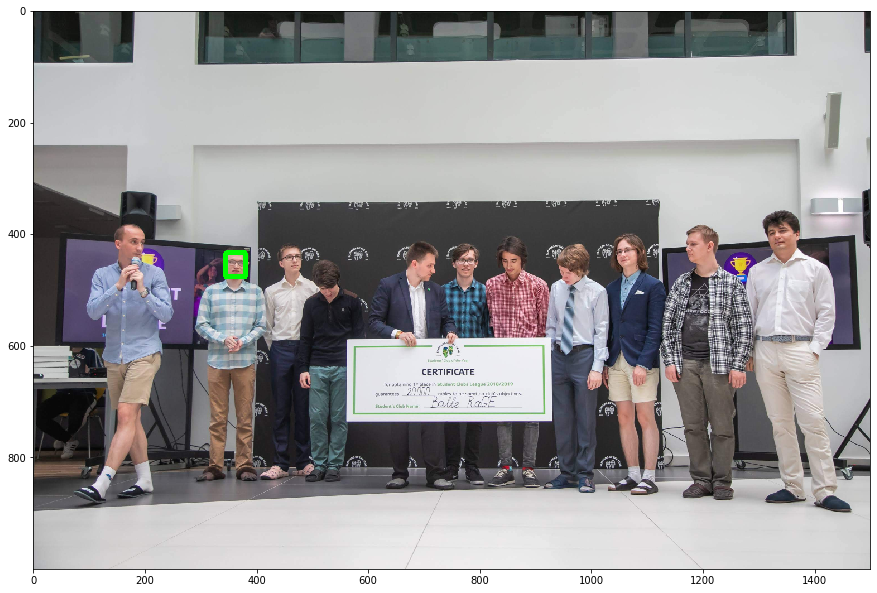

Finding faces in images:   1%|▎                                     | 3/440 [00:06<16:46,  2.30s/it]

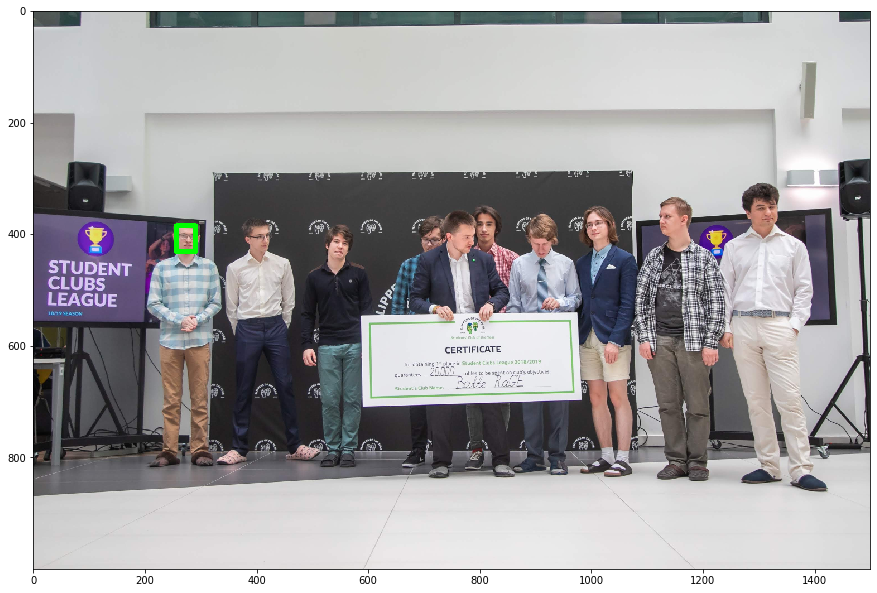

Finding faces in images:   1%|▍                                     | 5/440 [00:09<12:59,  1.79s/it]

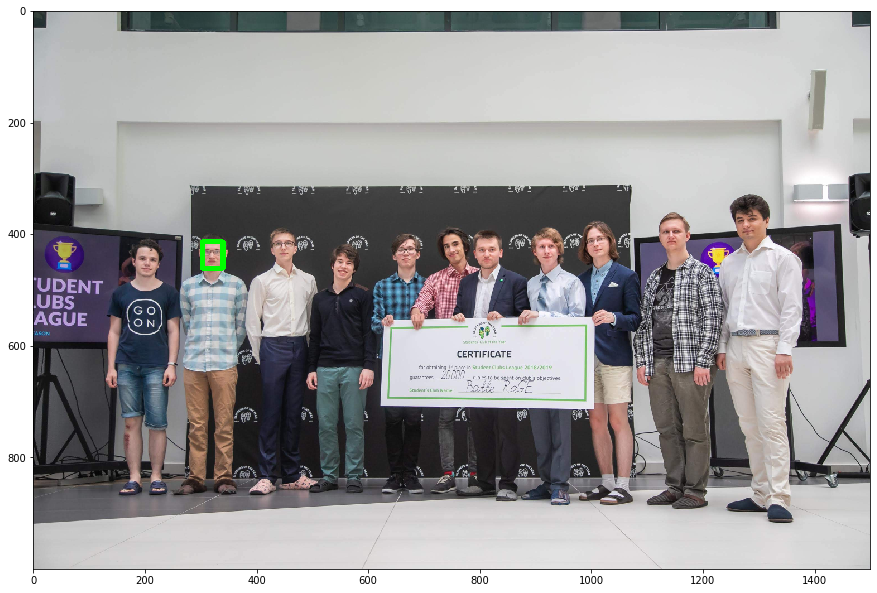

Finding faces in images:   1%|▌                                     | 6/440 [00:10<12:55,  1.79s/it]

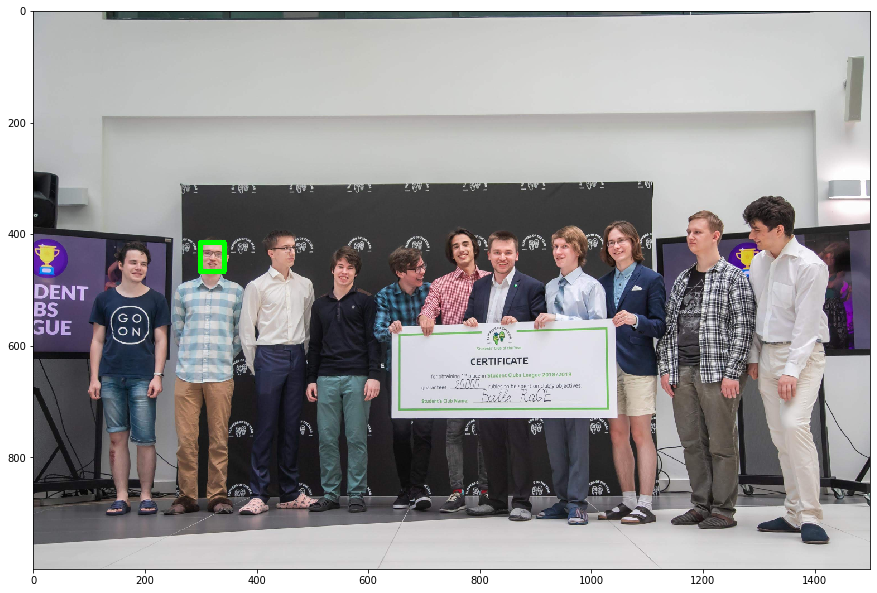

Finding faces in images:   9%|███▎                                 | 39/440 [00:37<05:06,  1.31it/s]

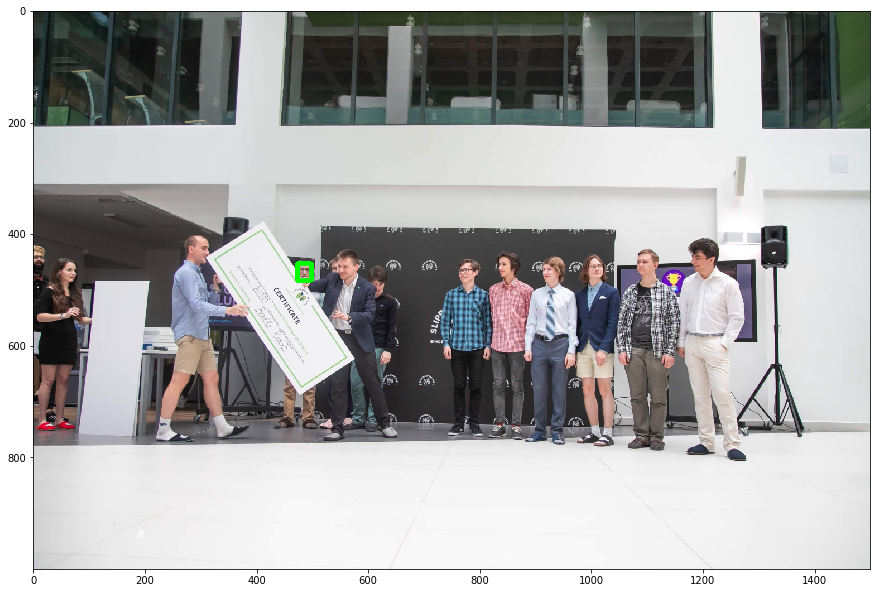

Finding faces in images: 100%|████████████████████████████████████| 440/440 [04:44<00:00,  1.55it/s]


In [14]:
images_with_person = []
# print('Num of images to process:', len(images))
for i, img in use_tqdm(enumerate(images),desc="Finding faces in images",total= len(images)):
    # Scale down for faster processing
    scale = 0.5
    small_img = cv2.resize(img, (0, 0), fx=scale, fy=scale)
    
    # Face detection
    face_locations = locate_faces(small_img)
    if len(face_locations) == 0:
        continue
    
    # Face extraction
    face_encodings = encode_faces(small_img, face_locations)
    # If no faces found, skip this image
    if len(face_encodings) == 0:
        continue
    
    # Face recognition
    matches = compare_faces(person_encoding, face_encodings)
    if any(matches):
        draw_faces(small_img, face_locations[matches])
        images_with_person.append(i)

In [17]:
images_with_person[:10], len(images_with_person)

([0, 1, 2, 3, 5, 6, 39], 7)

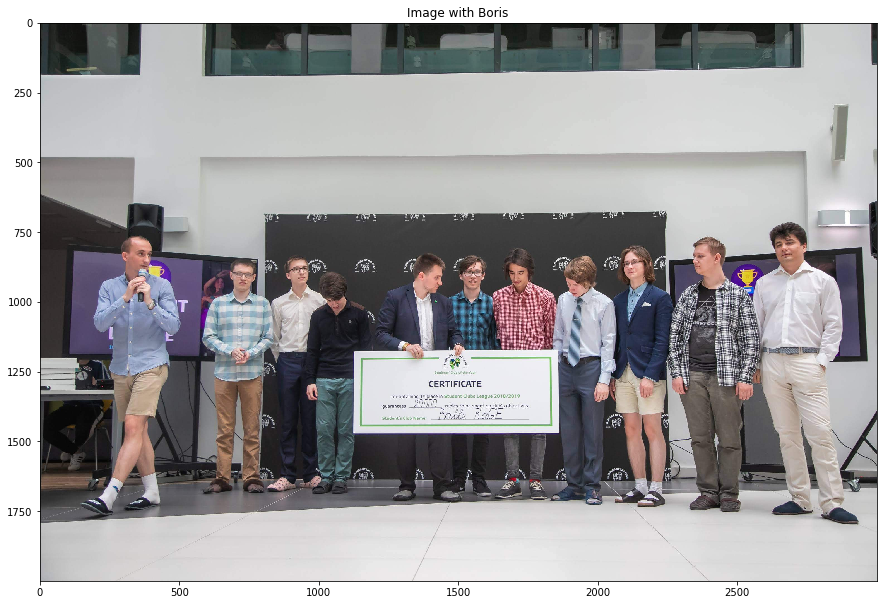

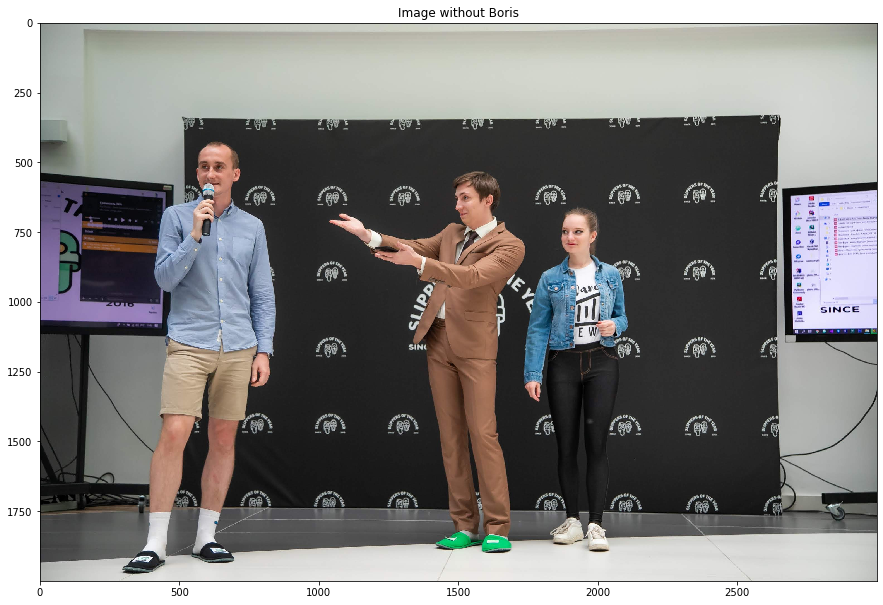

In [15]:
mask = np.zeros(len(images), dtype=bool)
mask[images_with_person] = True

if any(mask):
    plt.imshow(random.choice(images[mask]))
    plt.title(f'Image with {person_name}')
    plt.show()
else:
    print('No images with', person_name)

if any(~mask):
    plt.imshow(random.choice(images[~mask]))
    plt.title(f'Image without {person_name}')
    plt.show()
else:
    print('No images without', person_name)